In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

/Users/zkolter/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
url = "https://www.amazon.com/s/ref=sr_nr_p_72_3?fst=as%3Aoff&rh=n%3A165793011%2Cn%3A%21165795011%2Cn%3A196601011%2Cp_n_age_range%3A165890011%2Cp_85%3A2470955011%2Cp_76%3A1249179011%2Cp_72%3A1248966011&bbn=196601011&ie=UTF8&qid=1480525472&rnid=1248961011"

In [5]:
# scraping the right way removed
res = requests.get(url)
root = BeautifulSoup(res.content)

In [7]:
items = root.find_all("div", class_="s-item-container")

In [13]:
print items[0].find("img")["src"]
print items[0].find("a", class_="s-access-detail-page")["href"]


https://images-na.ssl-images-amazon.com/images/I/51mdwKj0suL._AC_US160_.jpg
https://www.amazon.com/VTech-80-166700-Musical-Rhymes-Book/dp/B00TEF3GSA/ref=sr_1_1/151-9526715-3150558?s=toys-and-games&rps=1&ie=UTF8&qid=1480525706&sr=1-1&refinements=p_n_age_range%3A165890011%2Cp_85%3A2470955011%2Cp_76%3A1249179011%2Cp_72%3A1248966011


In [15]:
root.find_all("span", class_="pagnLink")

[<span class="pagnLink"><a href="/s/ref=sr_pg_2/151-9526715-3150558?fst=as%3Aoff&amp;rh=n%3A165793011%2Cn%3A%21165795011%2Cn%3A196601011%2Cp_n_age_range%3A165890011%2Cp_85%3A2470955011%2Cp_76%3A1249179011%2Cp_72%3A1248966011&amp;page=2&amp;bbn=196601011&amp;ie=UTF8&amp;qid=1480525706">2</a></span>,
 <span class="pagnLink"><a href="/s/ref=sr_pg_3/151-9526715-3150558?fst=as%3Aoff&amp;rh=n%3A165793011%2Cn%3A%21165795011%2Cn%3A196601011%2Cp_n_age_range%3A165890011%2Cp_85%3A2470955011%2Cp_76%3A1249179011%2Cp_72%3A1248966011&amp;page=3&amp;bbn=196601011&amp;ie=UTF8&amp;qid=1480525706">3</a></span>]

In [ ]:
#### ....

In [19]:
import pickle 
urls = []
all_items = []
with open("output.pkl", "rb") as f:
    while True:
        try:
            urls.append(pickle.load(f))
            all_items += pickle.load(f)
        except:
            break


In [30]:
df = pd.DataFrame(all_items)

### Data cleaning and viz

In [31]:
df["num_ratings"] = df["num_ratings"].apply(lambda x : float(x.replace(",","")))
df["stars"] = df["stars"].apply(lambda x : float(x.split(" ")[0]))
df["rating"] = (df["stars"]-1.)/4

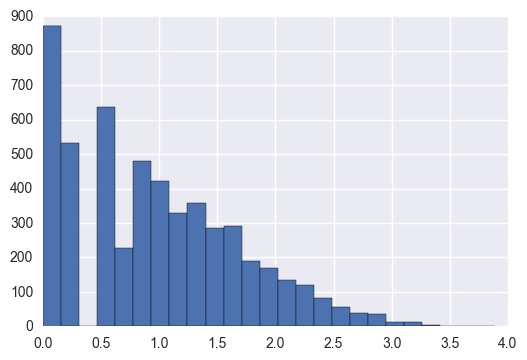

In [39]:
plt.hist(np.log10(df["num_ratings"]), bins=25);

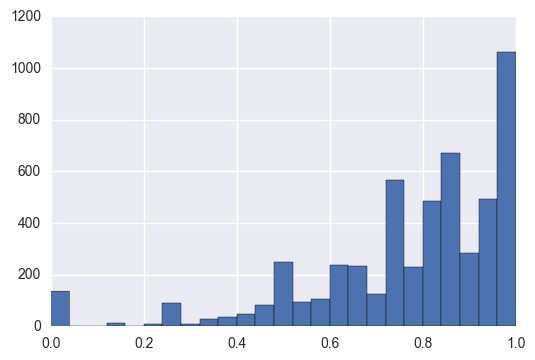

In [42]:
plt.hist(df["rating"], bins=25);

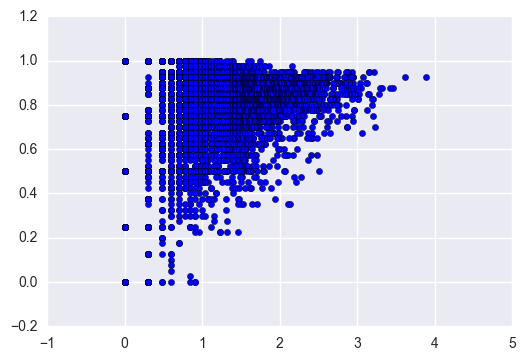

In [45]:
plt.scatter(np.log10(df["num_ratings"]), df["rating"])

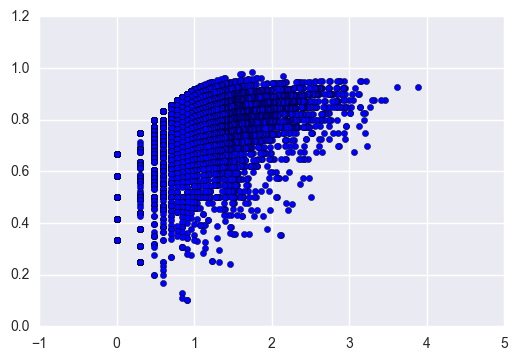

In [47]:
df["bayes_rating"] = (df["rating"]*df["num_ratings"] + 1)/(df["num_ratings"] + 2)
plt.scatter(np.log10(df["num_ratings"]), df["bayes_rating"])

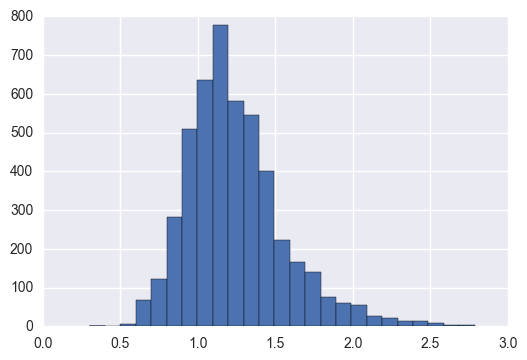

In [52]:
plt.hist(np.log10(df[~pd.isnull(df["price"])]["price"]), bins=25);

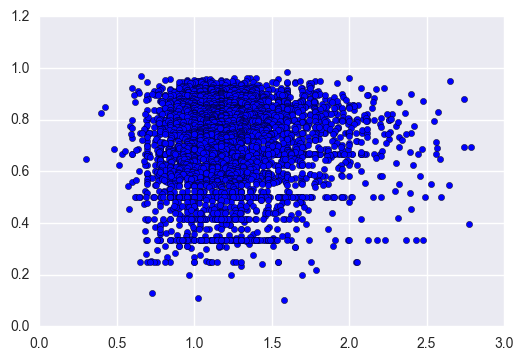

In [54]:
idx = ~pd.isnull(df["price"])
plt.scatter(np.log10(df[idx]["price"]), df[idx]["bayes_rating"]);

In [87]:
df.dropna(subset=["price"], inplace=True)
df.sort_values(by=["bayes_rating"], inplace=True, ascending=False)
df = df[df["num_ratings"] > 4]

### Machine learning

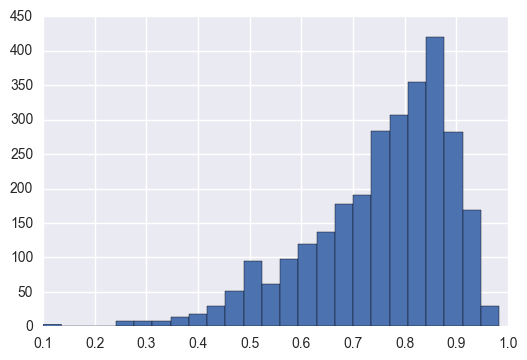

In [59]:
plt.hist(df["bayes_rating"], bins=25);

((array([-3.48928144, -3.24473462, -3.10945565, ...,  3.10945565,
          3.24473462,  3.48928144]),
  array([ 0.1       ,  0.11111111,  0.13055556, ...,  0.96296296,
          0.96840278,  0.98275862])),
 (0.1308746037341218, 0.7548142086141143, 0.96273485542964365))

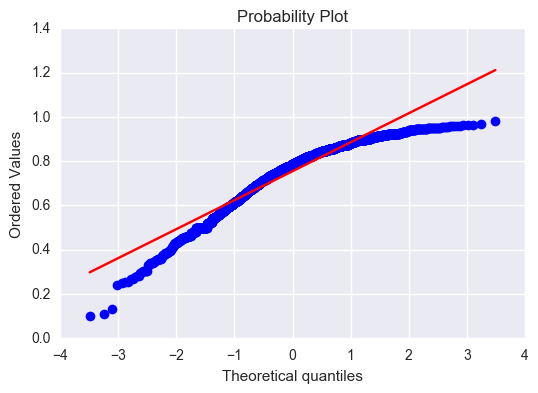

In [61]:
import scipy.stats as stats
stats.probplot(df["bayes_rating"], plot=plt)

In [62]:
df["logit_rating"] = np.log(df["bayes_rating"]/(1-df["bayes_rating"]))

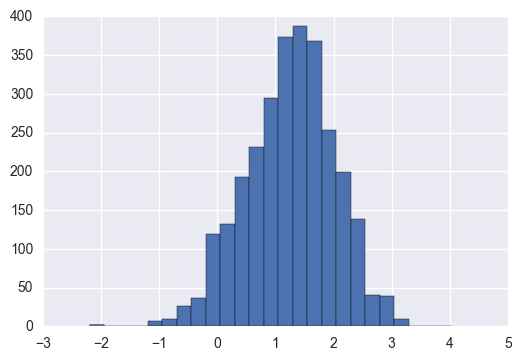

In [63]:
plt.hist(df["logit_rating"], bins=25);

((array([-3.48928144, -3.24473462, -3.10945565, ...,  3.10945565,
          3.24473462,  3.48928144]),
  array([-2.19722458, -2.07944154, -1.89605559, ...,  3.25809654,
          3.42257888,  4.04305127])),
 (0.76348494823149848, 1.2579066376129984, 0.99727626546078185))

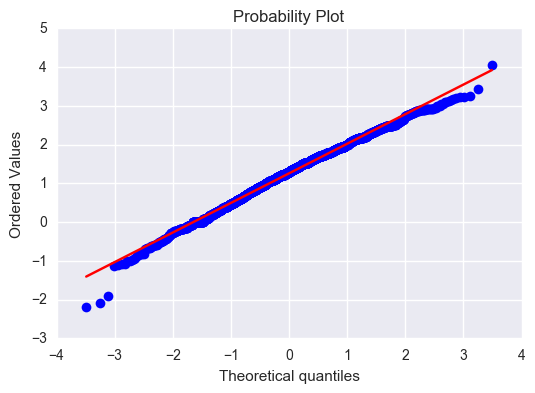

In [64]:
stats.probplot(df["logit_rating"], plot=plt)

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10, max_df=0.3, ngram_range=(1,3))

X_tfidf = tfidf.fit_transform(df["name"].values)
X = np.hstack([X_tfidf.toarray(), np.log(df[["price"]].values)])
y = df["logit_rating"].values

In [71]:
from sklearn.model_selection import train_test_split
X_, X_test, y_, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size=0.3, random_state=0)

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

clf = GradientBoostingRegressor()
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [77]:
print np.mean((clf.predict(X_train) - y_train)**2)
print np.mean((np.mean(y_train) - y_train)**2)
print 1 - np.mean((clf.predict(X_train) - y_train)**2)/np.mean((np.mean(y_train) - y_train)**2)

0.375174590596
0.582673672718
0.356115424185


In [78]:
print np.mean((clf.predict(X_cv) - y_cv)**2)
print np.mean((np.mean(y_train) - y_cv)**2)
print 1 - np.mean((clf.predict(X_cv) - y_cv)**2)/np.mean((np.mean(y_train) - y_cv)**2)

0.498200750721
0.556600879242
0.104922810399


In [79]:
print np.mean((clf.predict(X_test) - y_test)**2)
print np.mean((np.mean(y_train) - y_test)**2)
print 1 - np.mean((clf.predict(X_test) - y_test)**2)/np.mean((np.mean(y_train) - y_test)**2)

0.559603567536
0.608121317024
0.0797830106086


### Prediction game

In [80]:
import IPython.display as display
def display_item(s):
    display.display(display.Image(data=s["img_data"]))
    print s["name"]
    print "$" + str(np.round(s["price"], 2))
                    

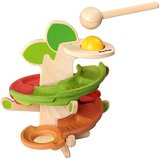

Plan Toys Click Clack Tree
$37.79


In [82]:
display_item(df.iloc[0])

In [93]:
def classification_game():
    it1 = np.random.randint(len(df)/10)
    it2 = np.random.randint(len(df)/10) + 9*len(df)/10
    if np.random.rand() < 0.5:
        it1,it2 = (it2, it1)
    display_item(df.iloc[it1])
    print "++++++++++++"
    display_item(df.iloc[it2])
    guess = input("Which has the higher rating (1/2)? ")
    print "True rating {} / {}".format(df.iloc[it1]["bayes_rating"], df.iloc[it2]["bayes_rating"])
    correct = ((guess ==1) and (it1 < it2)) or ((guess==2) and (it2 < it1))
    print "Correct" if correct else "Incorrect"
    

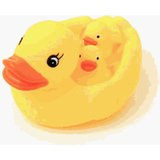

Set of 4 Floating and Squeaking Rubber Duck Bath Toys
$12.98
++++++++++++


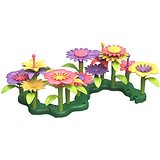

Green Toys Build-a-Bouquet Floral Arrangement Playset
$23.16
Which has the higher rating (1/2)? 2
True rating 0.5 / 0.923460144928
Correct


In [98]:
classification_game()

### Second ML take

In [104]:
idx = ((df["bayes_rating"] > np.percentile(df["bayes_rating"], 90)) |
       (df["bayes_rating"] < np.percentile(df["bayes_rating"], 10))).values
y = df["bayes_rating"] > np.median(df["bayes_rating"])

In [105]:
X_, X_test, y_, y_test = train_test_split(X[idx,:],y[idx], test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_, y_, test_size=0.3, random_state=0)

In [111]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=50, max_depth=2)
#clf.fit(X_train, y_train)
#print clf.score(X_train, y_train)
#print clf.score(X_cv, y_cv)

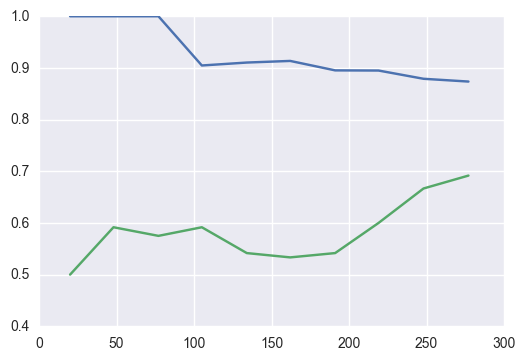

In [112]:
def get_err_samples(clf, X, y, X_cv, y_cv, n):
    clf.fit(X[:n], y[:n])
    return np.array([clf.score(X[:n], y[:n]), clf.score(X_cv, y_cv)])

nsamples = [int(x) for x in np.linspace(20, X_train.shape[0], 10)]
errors = np.array([get_err_samples(clf, X_train, y_train, X_cv, y_cv, n) for n in nsamples])
plt.plot(nsamples, errors[:,0], nsamples, errors[:,1])

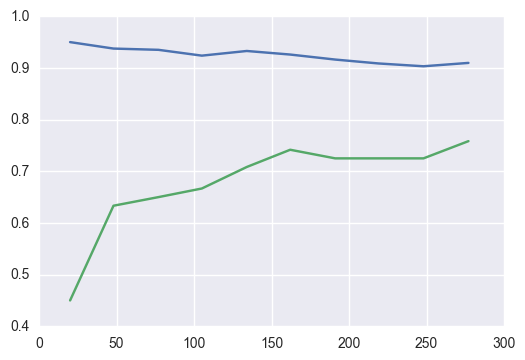

In [113]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
errors = np.array([get_err_samples(clf, X_train, y_train, X_cv, y_cv, n) for n in nsamples])
plt.plot(nsamples, errors[:,0], nsamples, errors[:,1])

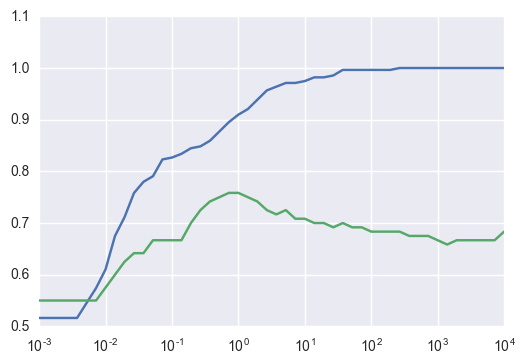

In [116]:
def get_err_reg(clf, X, y, X_cv, y_cv, C):
    clf.C = C
    clf.fit(X, y)
    return np.array([clf.score(X, y), clf.score(X_cv, y_cv)])

C = np.logspace(-3, 4, 50)
errors = np.array([get_err_reg(clf, X_train, y_train, X_cv, y_cv, c) for c in C])
plt.semilogx(C, errors[:,0], C, errors[:,1])

In [118]:
clf = LogisticRegression(C=0.8)
clf.fit(X_train, y_train)
print clf.score(X_train, y_train)
print clf.score(X_cv, y_cv)
print clf.score(X_test, y_test)

0.895306859206
0.758333333333
0.74269005848


In [121]:
feature_names = np.array(tfidf.get_feature_names() + ["$price"])
sorted(zip(feature_names, -clf.coef_[0]), key=lambda x : np.abs(x[1]), reverse=True)[:20]

[(u'toy', -0.95507761944856961),
 (u'doug', 0.911142237225674),
 (u'melissa doug', 0.911142237225674),
 (u'melissa', 0.90980208945226582),
 (u'green toys', 0.88179910415625495),
 (u'water', -0.86230787909934847),
 (u'and', 0.84266462028879874),
 (u'toys', 0.83411532541563582),
 (u'musical', -0.77471830295122746),
 (u'bath', -0.7232552698686302),
 (u'playskool', 0.70137695213482587),
 (u'fish', -0.68429822673188556),
 (u'blocks', 0.68101637123636227),
 (u'brio', 0.66706211726466003),
 (u'schylling', -0.66048239849819168),
 (u'imaginext', 0.65840574044803624),
 (u'ball', -0.63911500673562904),
 (u'green', 0.63623223122618189),
 (u'head', 0.62952658967930641),
 (u'preschool', 0.60688408822125639)]